# Compute Bray-Curtis distance

Computes Bray-Curtis distance between the composition of urban form within custom pre-defined boundaries.

In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
buildings = gpd.read_parquet("/data/uscuni-ulce/boundaries_of_change/classification/")

In [3]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1240_mongol_invasion,Polygon
1,900_political,Polygon
2,1000_political,Polygon
3,1300_ostsiedlung,Polygon
4,1550_religion,Polygon
5,1526_political,Polygon
6,1618_political,Polygon
7,1648_political,Polygon
8,1600_religion,Polygon
9,1812_political,Polygon


In [4]:
boundaries = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
boundaries= boundaries[boundaries.NAME != "Hungary"]

In [5]:
buildings.head()

,geometry,final_without_noise,area
__null_dask_index__,,,
0,POINT (4099683.344 3108236.287),50,66.767646
1,POINT (4100189.13 3108803.392),1,427.019080
2,POINT (4100069.189 3109146.3),1,144.324859
3,POINT (4100144.944 3108299.666),1,139.581363
4,POINT (4100022.946 3108688.179),1,41.651016


In [6]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v3.pq"
)
final_clusters

,1,2,3,4,5,6
7,,,,,,
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,2
4,1,1,1,1,1,2
5,1,1,1,1,2,3
...,...,...,...,...,...,...
104,2,4,8,16,31,59
105,2,4,8,16,31,59
106,2,4,8,16,32,60


In [7]:
level_columns = []

In [8]:
for level in final_clusters.columns:
    buildings[f"level_{level}"] = buildings.final_without_noise.map(
        final_clusters[level]
    )
    level_columns.append(f"level_{level}")

In [9]:
buildings.head()

,geometry,final_without_noise,area,level_1,level_2,level_3,level_4,level_5,level_6
__null_dask_index__,,,,,,,,,
0,POINT (4099683.344 3108236.287),50,66.767646,1,2,4,8,16,30
1,POINT (4100189.13 3108803.392),1,427.019080,1,1,1,1,1,1
2,POINT (4100069.189 3109146.3),1,144.324859,1,1,1,1,1,1
3,POINT (4100144.944 3108299.666),1,139.581363,1,1,1,1,1,1
4,POINT (4100022.946 3108688.179),1,41.651016,1,1,1,1,1,1


In [10]:
boundaries.explore()

In [11]:
boundaries.head()

,NAME,geometry
0,Slovakia,"MULTIPOLYGON (((4831478.004 2862677.86, 483257..."
2,Poland,"MULTIPOLYGON (((5234694.423 2962028.58, 520512..."
3,Czech Republic,"MULTIPOLYGON (((4611720.59 2845753.074, 459533..."
4,Austria,"MULTIPOLYGON (((4287832.026 2709688.594, 42879..."
5,Germany,"MULTIPOLYGON (((4143294.661 2722417.36, 414136..."


In [12]:
joined = gpd.sjoin(buildings, boundaries, how="left", predicate="within")
joined.head()

,geometry,final_without_noise,area,level_1,level_2,level_3,level_4,level_5,level_6,index_right,NAME
__null_dask_index__,,,,,,,,,,,
0,POINT (4099683.344 3108236.287),50,66.767646,1,2,4,8,16,30,5.0,Germany
1,POINT (4100189.13 3108803.392),1,427.019080,1,1,1,1,1,1,5.0,Germany
2,POINT (4100069.189 3109146.3),1,144.324859,1,1,1,1,1,1,5.0,Germany
3,POINT (4100144.944 3108299.666),1,139.581363,1,1,1,1,1,1,5.0,Germany
4,POINT (4100022.946 3108688.179),1,41.651016,1,1,1,1,1,1,5.0,Germany


In [13]:
grouped = joined.groupby("NAME")["level_4"].value_counts()

In [14]:
cnt_table = pd.DataFrame(grouped.unstack().fillna(0).T)
cnt_table = cnt_table.drop([3,4,10])
cnt_table

NAME,Austria,Czech Republic,Germany,Poland,Slovakia
level_4,,,,,
1,310835.0,666775.0,9569410.0,582582.0,192112.0
2,101458.0,53088.0,1011481.0,43807.0,16285.0
5,533384.0,455220.0,2974840.0,1416074.0,365544.0
6,88599.0,39914.0,10521782.0,115417.0,259672.0
7,544614.0,275808.0,6675004.0,398637.0,570353.0
8,440815.0,301470.0,10570624.0,542964.0,720751.0
9,177114.0,121855.0,100081.0,2805119.0,63444.0
11,525.0,3255.0,49133.0,740034.0,53020.0
12,11864.0,36266.0,410675.0,1796417.0,221357.0


In [15]:
region_building_sums = cnt_table.sum(axis=0)
cnt_table_norm = cnt_table.div(region_building_sums, axis=1)
cnt_table_norm.sum()

NAME
Austria           1.0
Czech Republic    1.0
Germany           1.0
Poland            1.0
Slovakia          1.0
dtype: float64

In [16]:
import scipy.stats as stats
from scipy.spatial import distance
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Bray-Curtis

In [17]:
cnt_table_norm.iloc[:,0]

level_4
1     0.068874
2     0.022481
5     0.118186
6     0.019631
7     0.120674
8     0.097674
9     0.039244
11    0.000116
12    0.002629
13    0.428218
14    0.060889
15    0.015262
16    0.006122
Name: Austria, dtype: float64

In [18]:
num_regions = len(cnt_table_norm.columns)

In [19]:
bray_curtis_matrix = np.zeros((num_regions, num_regions))

In [ ]:
for i in range(num_regions):
    for j in range(num_regions):
        if i != j:

            reg_i = cnt_table_norm.iloc[i]
            reg_j = cnt_table_norm.iloc[j]
            #numerator = 2*np.sum(np.minimum(reg_i,reg_j))
            #denominator = reg_i.sum() + reg_j.sum()
            #bray_curtis_matrix[i,j] = (1 - numerator/denominator)
            bray_curtis_matrix[i,j] = distance.braycurtis(reg_i, reg_j)
            #print(bray_curtis_matrix[i,j])

In [21]:
bray_curtis_matrix

array([[0.        , 0.78154202, 0.33731756, 0.31849768, 0.31906441],
       [0.78154202, 0.        , 0.77250465, 0.70653842, 0.7839711 ],
       [0.33731756, 0.77250465, 0.        , 0.56960814, 0.24606119],
       [0.31849768, 0.70653842, 0.56960814, 0.        , 0.41063057],
       [0.31906441, 0.7839711 , 0.24606119, 0.41063057, 0.        ]])

In [22]:
bray_curtis_matrix = pd.DataFrame(bray_curtis_matrix, index=cnt_table_norm.columns, columns=cnt_table_norm.columns)
bray_curtis_matrix

NAME,Austria,Czech Republic,Germany,Poland,Slovakia
NAME,,,,,
Austria,0.000000,0.781542,0.337318,0.318498,0.319064
Czech Republic,0.781542,0.000000,0.772505,0.706538,0.783971
Germany,0.337318,0.772505,0.000000,0.569608,0.246061
Poland,0.318498,0.706538,0.569608,0.000000,0.410631
Slovakia,0.319064,0.783971,0.246061,0.410631,0.000000


<Axes: xlabel='NAME', ylabel='NAME'>

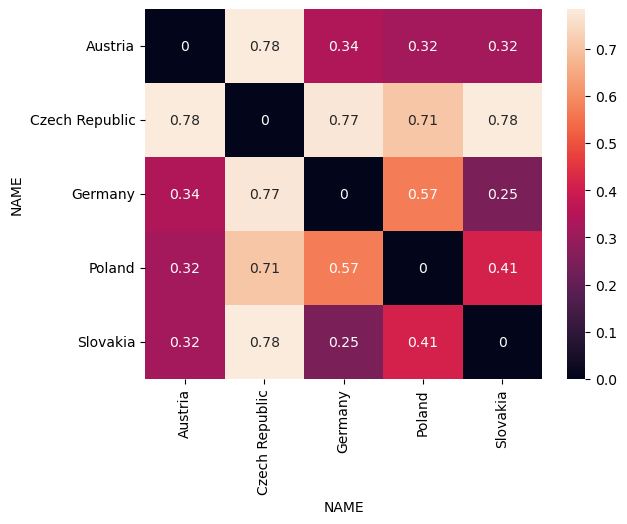

In [23]:
sns.heatmap(bray_curtis_matrix, annot=True)